In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import utils.functions as f
import json

import warnings

warnings.filterwarnings("ignore", message="Warning")

2025-06-13 16:40:59.310087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nlv19419/.pyenv/versions/3.11.12/envs/incartdb-venv/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


# Load the data
The export from the incart database is based on the header files of that database's format and some light processing in R. We load that file here and then continue the processing because most variables are factors that need to be transformed into numeric features.

In [3]:
dataset = "incartdb_demographics"
df = pd.read_csv(f"{dataset}.csv", sep=",")
df.head(10)

,header_file,id,age,gender,age_bin,diagnosis,present
0,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,"(60,65]",Coronary artery disease,1
1,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,"(60,65]",arterial hypertension,1
2,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,"(60,65]",Acute MI,0
3,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,"(60,65]",Transient ischemic attack,0
4,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,"(60,65]",left ventricular hypertrophy,0
5,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,"(60,65]",Earlier MI,0
6,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,"(60,65]",Sinus node dysfunction,0
7,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,F,"(60,65]",Coronary artery disease,1
8,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,F,"(60,65]",arterial hypertension,1
9,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,F,"(60,65]",Acute MI,0


In [4]:
df_processed = f.process_full_dataset(df, dataset_name=dataset)
df_processed.head(10)

,header_file,id,age,gender,age_bin,diagnosis,present
0,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,6,1,1
1,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,6,5,1
2,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,6,0,0
3,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,6,4,0
4,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,6,6,0
5,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,6,2,0
6,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,6,3,0
7,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,0,6,1,1
8,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,0,6,5,1
9,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,0,6,0,0


### Correlation Matrix

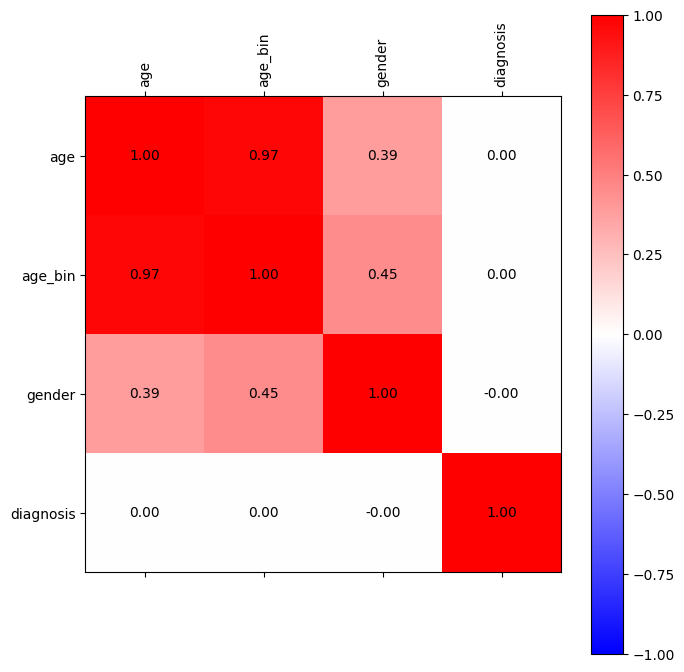

In [5]:
selected_columns = [
    "age",
    "age_bin",
    "gender", 
    "diagnosis"
]
f.plot_correlation_matrix(df_processed, selected_columns, figsize=(7,7))

# Bias Detection

## Gender Bias
Enconding:
- "Female": 0
- "Male": 1

In [6]:
df_processed.columns

Index(['header_file', 'id', 'age', 'gender', 'age_bin', 'diagnosis',
       'present'],
      dtype='object')

In the present use case, we only have one value per diagnosis for each of the metrics, so it makes no sense to plot the histograms. Instead, just show the resulting table.

In [18]:
gender_bias = f.show_bias(df_processed, "gender", 1, plot_histogram=False)

enc_file = open("utils/encodings/incartdb_demographics_diagnosis_encoding.json")
enc = json.load(enc_file)
reverse_enc = {int(value): key for key, value in enc.items()}
gender_bias['diagnosis'] = gender_bias['diagnosis'].replace(reverse_enc).astype(str)

gender_bias

/Users/nlv19419/.pyenv/versions/3.11.12/envs/incartdb-venv/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,Acute MI,0.000000,-0.150000,0.070000
1,Coronary artery disease,8.571429,0.378571,0.176667
2,Earlier MI,0.326531,-0.117857,0.055000
3,Sinus node dysfunction,inf,0.057143,0.026667
4,Transient ischemic attack,0.000000,-0.175000,0.081667
5,arterial hypertension,8.571429,0.378571,0.176667
6,left ventricular hypertrophy,5.142857,0.207143,0.096667


In [20]:
gender_bias[["disparate_impact", "statistical_parity_difference", "DIDI"]].corr()

,disparate_impact,statistical_parity_difference,DIDI
disparate_impact,1.000000,0.996984,0.945017
statistical_parity_difference,0.996984,1.000000,0.797887
DIDI,0.945017,0.797887,1.000000


## Location Bias

In [ ]:
location_bias = f.show_bias(df_processed, "same_location", 1, plot_histogram=True)

In [ ]:
location_bias.groupby("Sector")["Disparate_Impact"].describe()

In [ ]:
sector_location_bias = location_bias[location_bias["Sector"] == 4]
print("Tot: ", sector_location_bias["Job"].count())
print(
    "Less than 0.8: ",
    sector_location_bias[sector_location_bias["Disparate_Impact"] < 0.8]["Job"].count(),
)
print(
    "Between: ",
    sector_location_bias[
        (sector_location_bias["Disparate_Impact"] >= 0.8)
        & (sector_location_bias["Disparate_Impact"] < 1.3)
    ]["Job"].count(),
)
print(
    "More than 1.3",
    sector_location_bias[sector_location_bias["Disparate_Impact"] >= 1.3][
        "Job"
    ].count(),
)

In [ ]:
sector_location_bias.sort_values(by="Disparate_Impact", ascending=False)

In [ ]:
location_bias[["Disparate_Impact", "Statistical_Parity_Difference", "DIDI"]].corr()

### Region comparison

In [ ]:
location_bias_lombardia = f.show_bias(df_lombardia, "same_location", 1, plot_histogram=True)
location_bias_emilia = f.show_bias(df_emilia, "same_location", 1, plot_histogram=True)

In [ ]:
location_bias_lombardia.groupby("Sector")["Disparate_Impact"].describe()

In [ ]:
location_bias_emilia.groupby("Sector")["Disparate_Impact"].describe()

## Age Bias
Enconding:
- "15-24": 0
- "25-34": 1
- "35-44": 2
- "45-54": 3
- "55-74": 4

In [ ]:
age_bias = f.show_bias(df_processed, "cand_age_bucket", 1, plot_histogram=True)

In [ ]:
age_bias.groupby("Sector")["Disparate_Impact"].describe()

In [ ]:
sector_age_bias = age_bias[age_bias["Sector"] == 3]
print("Tot: ", sector_age_bias["Job"].count())
print(
    "Less than 0.8: ",
    sector_age_bias[sector_age_bias["Disparate_Impact"] < 0.8]["Job"].count(),
)
print(
    "Between: ",
    sector_age_bias[
        (sector_age_bias["Disparate_Impact"] >= 0.8)
        & (sector_age_bias["Disparate_Impact"] < 1.3)
    ]["Job"].count(),
)
print(
    "More than 1.3",
    sector_age_bias[sector_age_bias["Disparate_Impact"] >= 1.3]["Job"].count(),
)

In [ ]:
sector_age_bias.sort_values(by="Disparate_Impact", ascending=False)

In [ ]:
age_bias[["Disparate_Impact", "Statistical_Parity_Difference", "DIDI"]].corr()

### Region comparison

In [ ]:
age_bias_lombardia = f.show_bias(df_lombardia, "same_location", 1, plot_histogram=True)
age_bias_emilia = f.show_bias(df_emilia, "same_location", 1, plot_histogram=True)

In [ ]:
age_bias_lombardia.groupby("Sector")["Disparate_Impact"].describe()

In [ ]:
age_bias_emilia.groupby("Sector")["Disparate_Impact"].describe()